<a href="https://colab.research.google.com/github/BayramAlpSahin/EE491-492Project/blob/main/autoencoder_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import urllib.request
from urllib.error import HTTPError
import matplotlib
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torchvision import transforms
from torchvision.datasets import MNIST

In [ ]:
training_data = MNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.Compose(
        [transforms.ToTensor()]
    ),
)
test_data = MNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.Compose(
        [transforms.ToTensor()]
    ),
)

In [4]:
train_dataloader = data.DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = data.DataLoader(test_data, batch_size= 64, shuffle=True)

In [5]:
X, y = next(iter(train_dataloader))

In [9]:
class Autoencoder(nn.Module):
  def __init__ (self):
    super().__init__()
    self.encoder = nn.Sequential(
      nn.Conv2d(1, 16, 3, stride=1, padding=1),
      nn.ReLU(),
      nn.Conv2d(16, 16, 3, stride=2, padding=1),
      nn.ReLU(),
      nn.Conv2d(16, 16, 3, stride=1, padding=1),
      nn.ReLU(),
      nn.Conv2d(16, 32, 3, stride=2, padding=1),
      nn.ReLU(),
      nn.Conv2d(32, 64, 7),
      nn.ReLU())
    self.decoder = nn.Sequential(
      nn.ConvTranspose2d(64, 32, 7),
      nn.ReLU(),
      nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
      nn.ReLU(),
      nn.ConvTranspose2d(16, 16, 3, stride=1, padding=1),
      nn.ReLU(),
      nn.ConvTranspose2d(16, 16, 3, stride=2, padding=1, output_padding=1),
      nn.ReLU(),
      nn.ConvTranspose2d(16, 1, 3, stride=1, padding=1),
      nn.Tanh())
  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x


model = Autoencoder()
model.cuda()

In [ ]:
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

def train():
  model.train()
  for X, _ in train_dataloader:
    X = X.cuda()
    X_noise = X + 0.3 * torch.randn_like(X)
    X_noise = X_noise.clamp(0, 1)
    optimizer.zero_grad()
    output = model(X_noise)
    loss = loss_fn(output, X)
    loss.backward()
    optimizer.step()
  print(f"Loss: {loss.item()}")

def test():
  model.eval()
  test_loss = 0
  with torch.no_grad():
    for X, _ in test_dataloader:
      X = X.cuda()
      X_noise = X + 0.3 * torch.randn_like(X)
      X_noise = X_noise.clamp(0, 1)
      output = model(X_noise)
      test_loss += loss_fn(output, X).item()
    test_loss /= len(test_dataloader)
  print(f"Test loss: {test_loss}")

epochs = 10
for epoch in range(epochs):
  train()
  test()

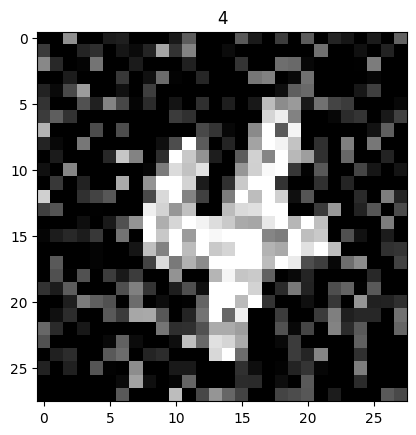

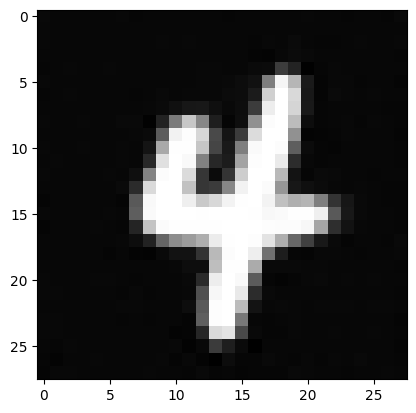

In [63]:
X, y = next(iter(test_dataloader))
X = X.cuda()
X_noise = X + 0.3 * torch.randn_like(X)
X_noise = X_noise.clamp(0, 1)
output = model(X_noise)

n = 55
plt.imshow(X_noise[n].cpu().detach().numpy().reshape(28, 28), cmap="gray")
plt.title(y[n].item())
plt.show()
plt.imshow(output[n].cpu().detach().numpy().reshape(28, 28), cmap="gray")
plt.show()